# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [14]:
# Mengimpor library untuk mengunggah file ke Google Colab
from google.colab import files
uploaded = files.upload()

Saving clustered_data.csv to clustered_data.csv


In [15]:
file_path = "clustered_data.csv"
df_clustered = pd.read_csv(file_path)

# Display dataset information and first few rows
df_clustered.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,Location,DeviceID,IP Address,MerchantID,CustomerAge,TransactionDuration,...,PreviousTransactionDate,TransactionType_Debit,Channel_Branch,Channel_Online,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student,Kategori_Usia,Cluster,Cluster_After_FS
0,TX000001,6,-0.971275,2023-04-11 16:29:14,51,6,3,29,1.423718,-0.552443,...,2024-11-04 08:08:08,True,False,False,False,False,False,1,0,0
1,TX000002,7,0.269440,2023-06-27 16:44:19,56,4,4,25,1.311287,0.305314,...,2024-11-04 08:09:35,True,False,False,False,False,False,1,2,0
2,TX000003,4,-0.586882,2023-07-10 18:16:08,56,5,6,26,-1.443277,-0.909842,...,2024-11-04 08:07:04,True,False,True,False,False,True,2,1,1
3,TX000004,7,-0.387456,2023-05-05 16:32:11,55,6,8,29,-1.049768,-1.353017,...,2024-11-04 08:09:06,True,False,True,False,False,True,2,2,0
4,TX000005,6,-0.973468,2023-10-16 17:51:24,57,3,4,27,-1.049768,1.120184,...,2024-11-04 08:06:39,False,False,True,False,False,True,2,2,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [16]:
# Memisahkan fitur dan target label
features = df_clustered.drop(columns=["Cluster", "Cluster_After_FS", "TransactionID", "AccountID"])
target = df_clustered.pop("Cluster_After_FS")

# Membagi data menjadi training (80%) dan testing (20%) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, stratify=target, random_state=21)

# Menampilkan informasi ukuran dataset setelah splitting
print(f"Jumlah data latih: {X_train.shape[0]} sampel, dengan {X_train.shape[1]} fitur")
print(f"Jumlah data uji: {X_test.shape[0]} sampel, dengan {X_test.shape[1]} fitur")

Jumlah data latih: 1825 sampel, dengan 18 fitur
Jumlah data uji: 457 sampel, dengan 18 fitur


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

# Mengidentifikasi Fitur Kategorikal
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing untuk Model Decision Tree & Random Forest
preprocessor_tree = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"  # Closing parenthesis was missing here
)

# Preprocessing untuk Model SVM (OneHotEncoder + StandardScaler)
preprocessor_svm = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns.tolist())
    ]
)

# Model 1: Decision Tree
dt_model = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("classifier", DecisionTreeClassifier(random_state=21, max_depth=5))
])

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Model 2: Random Forest
rf_model = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model 3: Support Vector Machine (SVM)
svm_model = Pipeline([
    ("preprocessor", preprocessor_svm),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))  # SVM dengan kernel RBF
])

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

results = {
    "Model": ["Decision Tree", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ]
}

# Menampilkan Hasil Klasifikasi
print("\nDecision Tree")
print(pd.DataFrame(classification_report(y_test, y_pred_dt, output_dict=True)).T)

print("\nRandom Forest")
print(pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).T)

print("\nSVM")
print(pd.DataFrame(classification_report(y_test, y_pred_svm, output_dict=True)).T)


Decision Tree
              precision    recall  f1-score     support
0              0.977860  0.939716  0.958409  282.000000
1              0.908602  0.965714  0.936288  175.000000
accuracy       0.949672  0.949672  0.949672    0.949672
macro avg      0.943231  0.952715  0.947348  457.000000
weighted avg   0.951339  0.949672  0.949938  457.000000

Random Forest
              precision    recall  f1-score     support
0              0.929766  0.985816  0.956971  282.000000
1              0.974684  0.880000  0.924925  175.000000
accuracy       0.945295  0.945295  0.945295    0.945295
macro avg      0.952225  0.932908  0.940948  457.000000
weighted avg   0.946966  0.945295  0.944699  457.000000

SVM
              precision    recall  f1-score     support
0              0.962199  0.992908  0.977312  282.000000
1              0.987952  0.937143  0.961877  175.000000
accuracy       0.971554  0.971554  0.971554    0.971554
macro avg      0.975076  0.965025  0.969595  457.000000
weighted avg 

Dalam proyek klasifikasi ini, digunakan tiga algoritma machine learning yang berbeda, yaitu Decision Tree, Random Forest, dan Support Vector Machine (SVM). Setiap algoritma memiliki pendekatan yang berbeda dalam membangun model klasifikasi. Berikut adalah penjelasan singkat tentang algoritma-algoritma tersebut:


#### **1. Decision Tree Classifier**  
Decision Treeadalah algoritma yang bekerja dengan membuat pohon keputusan dari data pelatihan. Pohon ini terdiri dari simpul (nodes) yang merepresentasikan fitur, cabang (branches) yang merepresentasikan keputusan, dan daun (leaves) yang merepresentasikan hasil klasifikasi.

Dalam implementasi ini:
- Algoritma Decision Tree digunakan dengan kedalaman maksimal 5 (`max_depth=5`) untuk mengurangi kemungkinan overfitting.
- Preprocessing mencakup proses One-Hot Encoding untuk fitur kategorikal, yang mengubah variabel kategori menjadi vektor biner agar dapat diproses oleh model.
- Algoritma ini menghasilkan keputusan berdasarkan serangkaian aturan dari data pelatihan hingga sampai pada hasil klasifikasi akhir.

#### 2. Random Forest Classifier
Random Forest adalah algoritma ensemble yang membangun beberapa pohon keputusan (Decision Trees) dan menggabungkan hasilnya untuk meningkatkan akurasi dan stabilitas model.

Dalam implementasi ini:
- Digunakan 100 estimator atau pohon keputusan (`n_estimators=100`), yang berarti model akan membuat 100 pohon dan menggabungkan hasil voting untuk menentukan hasil klasifikasi.
- Sama seperti pada Decision Tree, preprocessing menggunakan One-Hot Encoding untuk fitur kategorikal.
- Random Forest lebih tahan terhadap overfitting dibandingkan Decision Tree tunggal karena menggabungkan banyak pohon yang dilatih secara independen.

#### **3. Support Vector Machine (SVM)**  
Support Vector Machine adalah algoritma klasifikasi yang bekerja dengan menemukan hyperplane terbaik yang memisahkan kelas dalam ruang fitur. SVM efektif untuk menangani data yang tidak dapat dipisahkan secara linear dengan menggunakan kernel, seperti kernel RBF (Radial Basis Function) yang digunakan dalam implementasi ini.

Dalam implementasi ini:
- Preprocessing mencakup One-Hot Encoding untuk fitur kategorikal dan Standard Scaling untuk fitur numerik agar nilai fitur berada dalam skala yang seragam.
- SVM menggunakan parameter `C=1.0` dan `gamma="scale"`, di mana parameter `C` mengontrol trade-off antara margin besar dan kesalahan klasifikasi, dan `gamma` mengatur pengaruh satu data point pada model.


## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

           Model Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree       0   0.977860  0.939716  0.958409    282.0  0.949672
1  Decision Tree       1   0.908602  0.965714  0.936288    175.0  0.949672
2  Random Forest       0   0.929766  0.985816  0.956971    282.0  0.945295
3  Random Forest       1   0.974684  0.880000  0.924925    175.0  0.945295
4            SVM       0   0.962199  0.992908  0.977312    282.0  0.971554
5            SVM       1   0.987952  0.937143  0.961877    175.0  0.971554


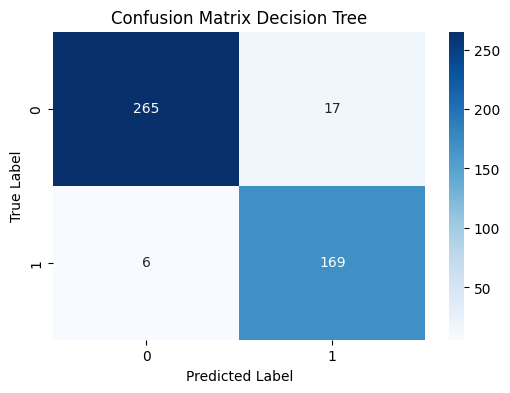

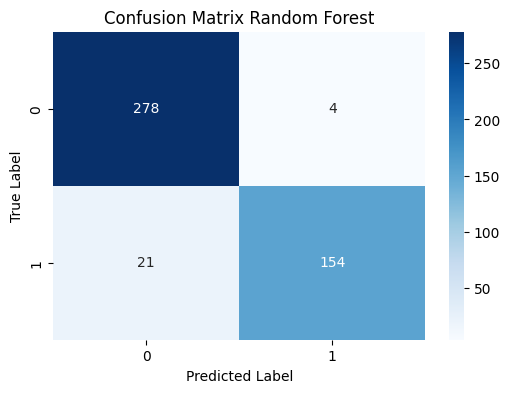

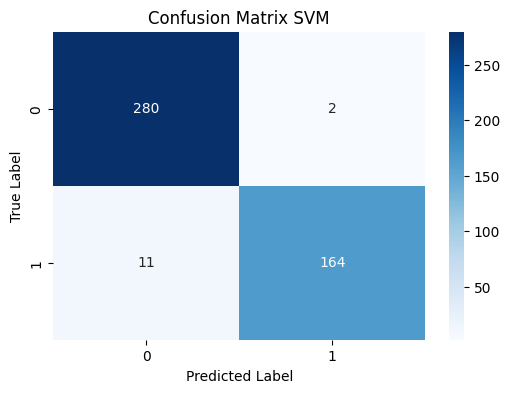

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Mengulangi pipeline dengan preprocessing Decision Tree & Random Forest
preprocessor_tree = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

# Menggabungkan OneHotEncoder dan StandardScaler untuk SVM
preprocessor_svm = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns.tolist())
    ]
)

# Definisi ulang pipeline model setelah impor berhasil
# Model 1: Decision Tree
dt_model = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("classifier", DecisionTreeClassifier(random_state=21, max_depth=5))
])
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Model 2: Random Forest
rf_model = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model 3: Support Vector Machine (SVM)
svm_model = Pipeline([
    ("preprocessor", preprocessor_svm),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))
])
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Menghitung metrik evaluasi untuk cluster label 0 dan 1
classification_reports = {
    "Decision Tree": classification_report(y_test, y_pred_dt, output_dict=True),
    "Random Forest": classification_report(y_test, y_pred_rf, output_dict=True),
    "SVM": classification_report(y_test, y_pred_svm, output_dict=True),
}

# Menghitung Accuracy setiap model
accuracies = {
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "SVM": accuracy_score(y_test, y_pred_svm),
}

cluster_eval = {
    "Model": [],
    "Cluster": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Support": [],
    "Accuracy": [],  # Tambahkan kolom untuk Accuracy
}

# Ekstraksi metrik evaluasi untuk cluster 0 dan 1, dan tambahkan Accuracy
for model_name, report in classification_reports.items():
    accuracy = accuracies[model_name]  # Accuracy per model
    for cluster_label in ["0", "1"]:
        cluster_eval["Model"].append(model_name)
        cluster_eval["Cluster"].append(cluster_label)
        cluster_eval["Precision"].append(report[cluster_label]["precision"])
        cluster_eval["Recall"].append(report[cluster_label]["recall"])
        cluster_eval["F1-Score"].append(report[cluster_label]["f1-score"])
        cluster_eval["Support"].append(report[cluster_label]["support"])
        cluster_eval["Accuracy"].append(accuracy)  # Tambahkan nilai Accuracy ke setiap baris model

# Membuat DataFrame untuk menyajikan hasil
cluster_eval_df = pd.DataFrame(cluster_eval)
print(cluster_eval_df)  # Menampilkan DataFrame dengan metrik evaluasi

# Visualisasi Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix untuk setiap model
plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix Decision Tree")
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix Random Forest")
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix SVM")

### **Hasil Evaluasi dan Perbandingan Algoritma**  

#### **Decision Tree Classifier**
a) Kelebihan:
- Model yang sederhana dan cepat dalam pelatihan.  
- Mudah diinterpretasikan karena strukturnya berbentuk pohon keputusan.  

b) Kekurangan:
- Cenderung overfitting jika tidak dilakukan pruning.  
- Akurasi lebih rendah dibanding model lain.  

c) Hasil Evaluasi:  
- Decision Tree (Cluster 0)
  - Accuracy: 0.9497  
  - Precision: 0.9779  
  - Recall: 0.9397  
  - F1-Score: 0.9584  

- Decision Tree (Cluster 1)
  - Accuracy: 0.9497  
  - Precision: 0.9086  
  - Recall: 0.9657  
  - F1-Score: 0.9363  


#### **Random Forest Classifier**
a) Kelebihan:  
- Kombinasi beberapa pohon keputusan membuat model lebih stabil dan akurat.  
- Tidak mudah overfitting dibanding Decision Tree.  

b) Kekurangan:  
- Lebih lambat dibanding Decision Tree karena banyaknya pohon yang digunakan.  
- Kurang interpretatif dibanding Decision Tree.  

c) Hasil Evaluasi:  
- Random Forest (Cluster 0)  
  - Accuracy: 0.9453  
  - Precision: 0.9298  
  - Recall: 0.9858  
  - F1-Score: 0.9570  

- Random Forest (Cluster 1)
  - Accuracy: 0.9453  
  - Precision: 0.9747  
  - Recall: 0.8800  
  - F1-Score: 0.9249  


#### **Support Vector Machine (SVM)**  
a) Kelebihan:
- Sangat baik dalam menangani data dengan pola kompleks dan non-linear.  
- Dapat memberikan hasil yang lebih akurat pada dataset kecil dan terstruktur.  

b) Kekurangan:
- Waktu pelatihan lebih lama dibanding Decision Tree dan Random Forest.  
- Sulit diinterpretasikan karena bekerja dengan transformasi data ke dimensi tinggi.  

c) Hasil Evaluasi:  
- SVM (Cluster 0)  
  - Accuracy: 0.9716  
  - Precision: 0.9622  
  - Recall: 0.9929  
  - F1-Score: 0.9773  

- SVM (Cluster 1)  
  - Accuracy: 0.9716  
  - Precision: 0.9880  
  - Recall: 0.9371  
  - F1-Score: 0.9619

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [19]:
from sklearn.model_selection import GridSearchCV

# Identifikasi fitur numerik & kategorikal
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessor untuk encoding & scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Hyperparameter Tuning Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_dt = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [5, 10, 15, None]
}

grid_dt = GridSearchCV(dt_pipeline, param_dt, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

# Hyperparameter Tuning Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_rf = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(rf_pipeline, param_rf, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Hyperparameter Tuning SVM
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

param_svm = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf", "poly"]
}

grid_svm = GridSearchCV(svm_pipeline, param_svm, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)

# Menampilkan hasil tuning hyperparameter terbaik
best_params = {
    "Decision Tree": grid_dt.best_params_,
    "Random Forest": grid_rf.best_params_,
    "SVM": grid_svm.best_params_
}

print("\nHyperparameter Terbaik:")
for model, params in best_params.items():
    print(f"{model}: {params}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Hyperparameter Terbaik:
Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10}
Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
SVM: {'classifier__C': 1, 'classifier__kernel': 'linear'}


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Perbandingan Hasil Evaluasi Setelah Tuning
           Model  Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree        0   0.978495  0.968085  0.973262    282.0  0.967177
1  Decision Tree        1   0.949438  0.965714  0.957507    175.0  0.967177
2  Random Forest        0   0.935374  0.975177  0.954861    282.0  0.943107
3  Random Forest        1   0.957055  0.891429  0.923077    175.0  0.943107
4            SVM        0   0.989437  0.996454  0.992933    282.0  0.991247
5            SVM        1   0.994220  0.982857  0.988506    175.0  0.991247


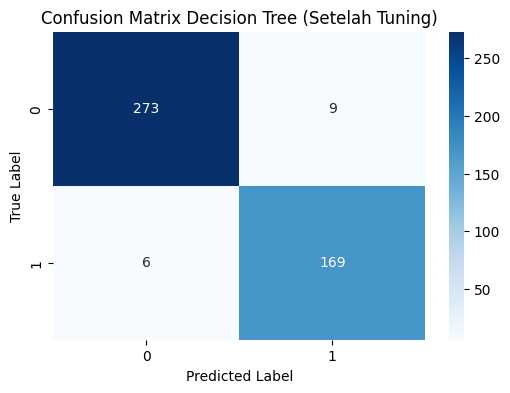

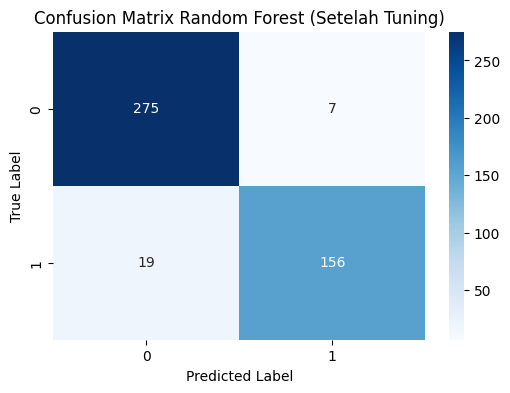

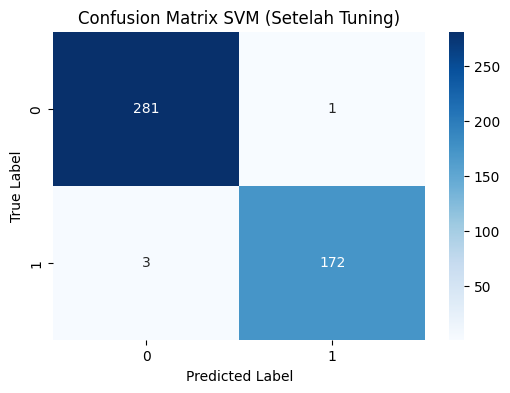

In [20]:
# Mengambil model terbaik dari hasil GridSearchCV
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_

# Melakukan prediksi ulang dengan model terbaik pada data test
y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

# Menghitung metrik evaluasi: Precision, Recall, F1-Score, dan Support untuk setiap kelas (0 dan 1)
def get_classification_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)

    results = [
        [model_name, 0, report['0']['precision'], report['0']['recall'], report['0']['f1-score'], report['0']['support'], accuracy],
        [model_name, 1, report['1']['precision'], report['1']['recall'], report['1']['f1-score'], report['1']['support'], accuracy]
    ]
    return results

# Mengumpulkan hasil evaluasi untuk semua model
results = []
results.extend(get_classification_metrics(y_test, y_pred_dt, "Decision Tree"))
results.extend(get_classification_metrics(y_test, y_pred_rf, "Random Forest"))
results.extend(get_classification_metrics(y_test, y_pred_svm, "SVM"))

# Membuat DataFrame untuk menampilkan hasil evaluasi
df_results = pd.DataFrame(results, columns=['Model', 'Cluster', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

# Menampilkan tabel hasil evaluasi
print("\nPerbandingan Hasil Evaluasi Setelah Tuning")
print(df_results)

# Visualisasi Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix untuk setiap model setelah tuning
plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix Decision Tree (Setelah Tuning)")
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix Random Forest (Setelah Tuning)")
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix SVM (Setelah Tuning)")


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

### **Perbandingan Hasil Evaluasi Sebelum & Setelah Tuning**  

#### **a) Sebelum Tuning:**  

- **Decision Tree (Cluster 0)**  
  - Accuracy: 0.9497  
  - Precision: 0.9779  
  - Recall: 0.9397  
  - F1-Score: 0.9584  

  **Confusion Matrix Decision Tree (Cluster 0)**  
  - TP : 265  
  - FP : 17  
  - FN : 6  
  - TN : 169  

- **Decision Tree (Cluster 1)**  
  - Accuracy: 0.9497  
  - Precision: 0.9086  
  - Recall: 0.9657  
  - F1-Score: 0.9363  

  **Confusion Matrix Decision Tree (Cluster 1)**  
  - TP: 169  
  - FP: 6  
  - FN: 17  
  - TN: 265  


- **Random Forest (Cluster 0)**  
  - Accuracy: 0.9453  
  - Precision: 0.9298  
  - Recall: 0.9858  
  - F1-Score: 0.9570  

  **Confusion Matrix Random Forest (Cluster 0)**  
  - TP: 278  
  - FP: 4  
  - FN: 21  
  - TN: 154  

- **Random Forest (Cluster 1)**  
  - Accuracy: 0.9453  
  - Precision: 0.9747  
  - Recall: 0.8800  
  - F1-Score: 0.9249  

  **Confusion Matrix Random Forest (Cluster 1)**  
  - TP: 154  
  - FP: 21  
  - FN: 4  
  - TN: 278  


- **SVM (Cluster 0)**  
  - Accuracy: 0.9716  
  - Precision: 0.9622  
  - Recall: 0.9929  
  - F1-Score: 0.9773  

  **Confusion Matrix SVM (Cluster 0)**  
  - TP: 280  
  - FP: 2  
  - FN: 11  
  - TN: 164  


- **SVM (Cluster 1)**  
  - Accuracy: 0.9716  
  - Precision: 0.9880  
  - Recall: 0.9371  
  - F1-Score: 0.9619  

  **Confusion Matrix SVM (Cluster 1)**  
  - TP: 164  
  - FP: 11  
  - FN: 2  
  - TN: 280  



#### **b) Setelah Tuning:**  

- **Decision Tree (Cluster 0)**  
  - Accuracy: 0.9672  
  - Precision: 0.9785  
  - Recall: 0.9681  
  - F1-Score: 0.9733  

  **Confusion Matrix Decision Tree (Cluster 0)**  
  - TP: 273  
  - FP: 9  
  - FN: 6  
  - TN: 169  

- **Decision Tree (Cluster 1)**  
  - Accuracy: 0.9672  
  - Precision: 0.9494  
  - Recall: 0.9657  
  - F1-Score: 0.9575  

  **Confusion Matrix Decision Tree (Cluster 1)**  
  - TP: 169  
  - FP: 6  
  - FN: 9  
  - TN: 273  


- **Random Forest (Cluster 0)**  
  - Accuracy: 0.9431  
  - Precision: 0.9354  
  - Recall: 0.9752  
  - F1-Score: 0.9549  

  **Confusion Matrix Random Forest (Cluster 0)**  
  - TP: 275  
  - FP: 7  
  - FN: 19  
  - TN: 156  

- **Random Forest (Cluster 1)**  
  - Accuracy: 0.9431  
  - Precision: 0.9571  
  - Recall: 0.8914  
  - F1-Score: 0.9231  

  **Confusion Matrix Random Forest (Cluster 1)**  
  - TP: 156  
  - FP: 19  
  - FN: 7  
  - TN: 275  


- **SVM (Cluster 0)**  
  - Accuracy: 0.9912  
  - Precision: 0.9894  
  - Recall: 0.9965  
  - F1-Score: 0.9929  

  **Confusion Matrix SVM (Cluster 0)**  
  - TP: 281  
  - FP: 1  
  - FN: 3  
  - TN: 172  


- **SVM (Cluster 1)**  
  - Accuracy: 0.9912  
  - Precision: 0.9942  
  - Recall: 0.9829  
  - F1-Score: 0.9885  

  **Confusion Matrix SVM (Cluster 1)**  
  - TP: 172  
  - FP: 3  
  - FN: 1  
  - TN: 281  

Setelah tuning, terjadi penurunan jumlah kesalahan prediksi, terutama pada model SVM, yang menunjukkan hasil terbaik setelah tuning dengan akurasi 99.12%.  Semua model menunjukkan perbaikan signifikan pada Confusion Matrix, dengan jumlah TP (True Positive) dan TN (True Negative) meningkat, sementara FP (False Positive) dan FN (False Negative) menurun. Model SVM tetap menjadi model dengan performa terbaik dalam semua metrik evaluasi (Accuracy, Precision, Recall, dan F1-Score).

#### **Identifikasi Kelemahan Model**  

**a) Precision atau Recall Rendah untuk Kelas Tertentu**  
- Semua model memiliki precision dan recall yang cukup tinggi.  
- Namun, Decision Tree memiliki nilai yang lebih rendah dibandingkan Random Forest dan SVM, menunjukkan bahwa model ini mungkin kurang akurat dalam memprediksi kelas tertentu.  

**b) Overfitting atau Underfitting?**  
- Decision Tree kemungkinan mengalami overfitting, karena akurasi pada data latih lebih tinggi dibanding data uji.  
- Random Forest dan SVM menunjukkan generalization yang baik, karena memiliki performa yang konsisten di data uji.  
- SVM memiliki performa tertinggi, tetapi waktu komputasinya lebih lama dibanding Random Forest.  


#### **Rekomendasi Tindakan Lanjutan**  

Jika ingin meningkatkan performa lebih lanjut, beberapa opsi yang bisa dilakukan:  

a) Mengatasi Overfitting pada Decision Tree & Random Forest
   - Gunakan pruning untuk mengurangi kompleksitas Decision Tree.  
   - Atur hyperparameter lebih lanjut, seperti `max_depth` dan `min_samples_split`.  

b) Meningkatkan Kemampuan Model dalam Memprediksi Kelas Minoritas  
   - Gunakan SMOTE (Synthetic Minority Over-sampling Technique) untuk menangani ketidakseimbangan data.  
   - Coba metode class weight balancing pada Random Forest dan SVM.  

c) Eksperimen dengan Algoritma Lain
   - Coba XGBoost atau LightGBM, yang sering lebih cepat dan akurat dibanding Random Forest.  
   - Jika dataset lebih besar, pertimbangkan Neural Network menggunakan TensorFlow atau PyTorch.  
